# Project: Image Classification and Regression
## Caroline Favart

### Importing libraries :

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

### Data generation functions :

These are the initial functions given. I only made changes to the generate_a_triangle function, in order to sort the vertices and to make the training of the regression more performant.

In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

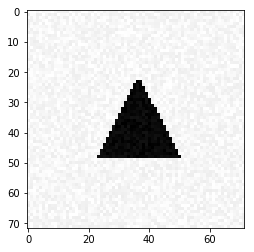

In [3]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3).reshape((1,-1))
        V = np.random.random(3).reshape((1,-1))
        
        ##We want to sort the triangle vertices to improve the regression
        vertices = np.concatenate((U,V),axis=0)
        vertices = vertices[:,vertices[0,:].argsort()]
        U = vertices[0]
        V = vertices[1]
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



To avoid changing results, we set a random seed.

In [4]:
# Setting a seed : 
seed=7
np.random.seed(seed)

## 3. Simple Classification

In this question, we want to build and train a linear classifier taking as input an image and classifying it between the 3 different categories / shapes possible : rectangle, disk, triangle.  
I first used the stochastic gradient descent optimizer, then the Adam optimizer.

### Dataset creation 

In [5]:
# We create a dataset of 300 samples, with noise 20
[X_train, Y_train] = generate_dataset_classification(300, 20)

# We need to convert Y_train from a vector with 0,1 or 2 into a 3 columns vector 
# with 0 or 1 in each shape (rectangle, disk,triangle)
from keras.utils import np_utils
y_train = np_utils.to_categorical(Y_train, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Using TensorFlow backend.


(300, 5184) (300,)


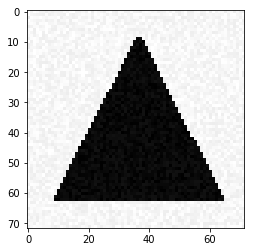

In [6]:
# Data visualization: plotting some images
plt.imshow(X_train[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# Info :
print(X_train.shape, Y_train.shape)

## Creating a classifier with SGD

A linear classifier is a one-layer model. We will create a Sequential model, add one Dense layer (with 3 neurons as we want to classify the dataset into 3 categories) and activate it with the function softmax, to have a value between 0 and 1, which we will interpret as the probability to be in each category. 

For the optimization, we will first use SGD. We decrease its learning rate to increase its precision. We compile the model using categorical_crossentropy as loss function (good for a classification) and accuracy as metrics. 

Finally, we train the model on our training set, with 100 epochs and a batch size of 5.


In [7]:
# Creating a linear classifier in Keras, with SGD

from keras.models import Sequential
from keras.layers import Dense, Activation


# Define the network : 

model_sgd=Sequential()

# We add one Dense layer with 3 neurons and activate it with softmax

model_sgd.add(Dense(3,input_shape=(X_train.shape[1],)))
model_sgd.add(Activation('softmax'))

# Define optimization framework

# We use SGD and specify its learning rate and momentum.
from keras.optimizers import SGD
sgd = SGD(lr=1e-4, momentum=0.9)

model_sgd.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Model fitting :

model_sgd.fit(X_train, y_train, epochs=100, batch_size=5, validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - 1s 3ms/step - loss: 1.0708 - acc: 0.4926 - val_loss: 0.8610 - val_acc: 0.7000
Epoch 2/100
270/270 [==============================] - 0s 628us/step - loss: 0.7256 - acc: 0.7037 - val_loss: 0.5415 - val_acc: 0.9333
Epoch 3/100
270/270 [==============================] - 0s 652us/step - loss: 0.5512 - acc: 0.7926 - val_loss: 0.4290 - val_acc: 0.9000
Epoch 4/100
270/270 [==============================] - 0s 688us/step - loss: 0.4906 - acc: 0.8481 - val_loss: 0.7223 - val_acc: 0.6000
Epoch 5/100
270/270 [==============================] - 0s 783us/step - loss: 0.5002 - acc: 0.7963 - val_loss: 0.3318 - val_acc: 0.9667
Epoch 6/100
270/270 [==============================] - 0s 787us/step - loss: 0.3981 - acc: 0.8704 - val_loss: 0.3107 - val_acc: 0.9667
Epoch 7/100
270/270 [==============================] - 0s 728us/step - loss: 0.3703 - acc: 0.8704 - val_loss: 0.3494 - val_acc: 0.9000
Epoch 8/100


Epoch 61/100
270/270 [==============================] - 0s 639us/step - loss: 0.0767 - acc: 0.9926 - val_loss: 0.0611 - val_acc: 1.0000
Epoch 62/100
270/270 [==============================] - 0s 700us/step - loss: 0.0682 - acc: 1.0000 - val_loss: 0.0682 - val_acc: 1.0000
Epoch 63/100
270/270 [==============================] - 0s 729us/step - loss: 0.0735 - acc: 0.9889 - val_loss: 0.0663 - val_acc: 1.0000
Epoch 64/100
270/270 [==============================] - 0s 688us/step - loss: 0.0673 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 1.0000
Epoch 65/100
270/270 [==============================] - 0s 658us/step - loss: 0.0688 - acc: 0.9926 - val_loss: 0.0631 - val_acc: 1.0000
Epoch 66/100
270/270 [==============================] - 0s 667us/step - loss: 0.0692 - acc: 0.9963 - val_loss: 0.0726 - val_acc: 1.0000
Epoch 67/100
270/270 [==============================] - 0s 759us/step - loss: 0.0650 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 1.0000
Epoch 68/100
270/270 [==========================

### Testing the first classifier on each shape

[[0. 1. 0.]]


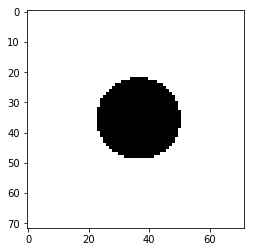

In [8]:
# On a circle : 

# We generate a disk and reshape it
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])

# We predict the category

X_test_pred=model_sgd.predict(X_test)
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

print(X_test_pred)

The one is in the second column, it's a disk ! 

[[1. 0. 0.]]


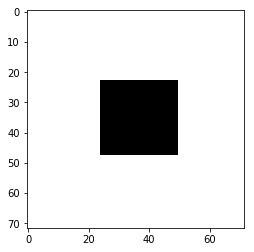

In [9]:
# On a rectangle,we follow the same process 

X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])

X_test_pred=model_sgd.predict(X_test)
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

print(X_test_pred)

The one is in the first column, it's a rectangle !

[[0. 0. 1.]]


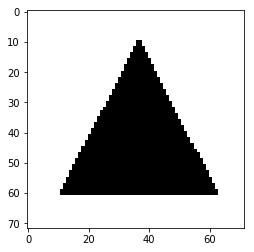

In [10]:
# On a triangle,we follow the same process 

X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])

X_test_pred=model_sgd.predict(X_test)
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

print(X_test_pred)

The one is in the third column, it's a triangle! 

## Creating a classifier with Adam

In [11]:
# Linear classifier in Keras

from keras.models import Sequential
from keras.layers import Dense, Activation

# Create the same model with Adam optimizer :
model_adam=Sequential()
model_adam.add(Dense(3,input_shape=(X_train.shape[1],)))
model_adam.add(Activation('softmax'))

# Define optimization framework

from keras.optimizers import Adam
adam=Adam(lr = 1e-4)
model_adam.compile(loss='categorical_crossentropy', optimizer=adam,
              metrics=['accuracy'])

# Fitting :
model_adam.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/50
270/270 [==============================] - 1s 3ms/step - loss: 1.1398 - acc: 0.3593 - val_loss: 1.0624 - val_acc: 0.3000
Epoch 2/50
270/270 [==============================] - 0s 202us/step - loss: 0.9548 - acc: 0.4778 - val_loss: 0.9456 - val_acc: 0.6333
Epoch 3/50
270/270 [==============================] - 0s 267us/step - loss: 0.8722 - acc: 0.6259 - val_loss: 0.8450 - val_acc: 0.7333
Epoch 4/50
270/270 [==============================] - 0s 266us/step - loss: 0.7911 - acc: 0.7296 - val_loss: 0.7474 - val_acc: 0.7667
Epoch 5/50
270/270 [==============================] - 0s 219us/step - loss: 0.7326 - acc: 0.7519 - val_loss: 0.7047 - val_acc: 0.8000
Epoch 6/50
270/270 [==============================] - 0s 205us/step - loss: 0.6841 - acc: 0.7519 - val_loss: 0.6408 - val_acc: 0.8000
Epoch 7/50
270/270 [==============================] - 0s 201us/step - loss: 0.6355 - acc: 0.8222 - val_loss: 0.5939 - val_acc: 0.8333
Epoch 8/50
270/270 

## Testing Adam

[[0. 0. 1.]]


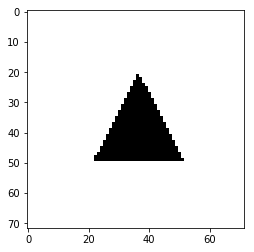

In [12]:
# On a triangle
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])

X_test_pred=model_adam.predict(X_test)
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

print(X_test_pred)

It's a triangle (one in the third column)

[[1. 0. 0.]]


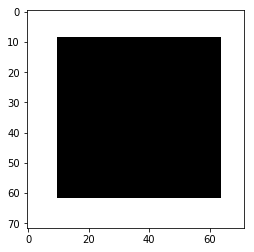

In [13]:
# On a rectangle :
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])

X_test_pred=model_adam.predict(X_test)
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

print(X_test_pred)

It's a rectangle ! 

[[0. 1. 0.]]


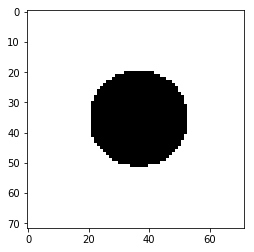

In [14]:
X_test2 = generate_a_disk()
X_test2 = X_test2.reshape(1, X_test2.shape[0])

X_test2_pred=model_adam.predict(X_test2)
plt.imshow(X_test2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

print(X_test2_pred)

It's a disk ! 

## 4.Visualization of the Solution


We would like to visualize the weights of the linear classifier for each optimizer, which means visualizing how each pixel is important for each category, using the function model.get_weights().
The first element of the output is a matrix with 3 columns (categories) and 5184 lines (pixels).

In [15]:
# Shape of the output :
print(model_sgd.get_weights()[0].shape)


# Weights for each model :
weights_sgd=model_sgd.get_weights()
weights_adam=model_adam.get_weights()

(5184, 3)


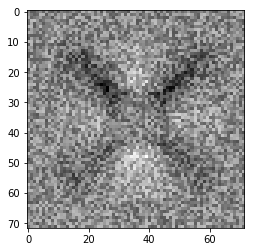

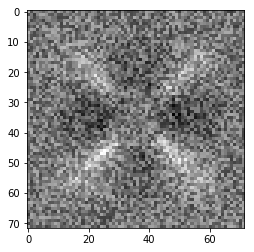

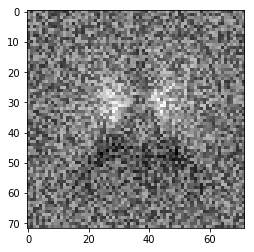

In [16]:
# Visualization for SGD :
col1=weights_sgd[0][:,0]
col2=weights_sgd[0][:,1]
col3=weights_sgd[0][:,2]
plt.imshow(col1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(col2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(col3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

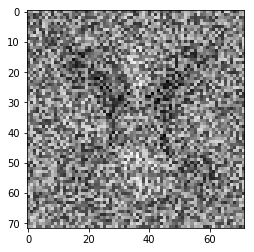

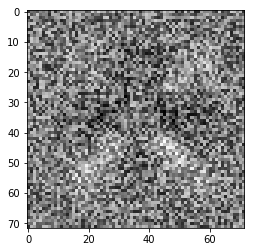

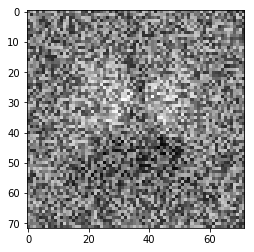

In [17]:
# Visualization for SGD :
col1=weights_adam[0][:,0]
col2=weights_adam[0][:,1]
col3=weights_adam[0][:,2]
plt.imshow(col1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(col2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(col3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

### Conclusion: 
Globally, we can observe the lines that impact the classification (diagonals) and center.
It seems that the SGD classifier has clearer patterns, which we could interpret as more performant in the classification (as it interprets patterns in the picture). 
In the center of the images, we can almost distinguinsh shapes too. 


## EX5 : 5 A More Difficult Classification Problem

In this exercise, we set the free_location argument to True, so the shapes are allowed to move within the images and change dimensions. 
We generate the new training set with generate_dataset_classification(300, 20, True). 

### Data generation

In [18]:
# Using the above-mentionned function :
[X_train5, Y_train5] = generate_dataset_classification(300, 20, True)
[X_test5, Y_test5] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [19]:
# Reshaping the data :
y_train5 = np_utils.to_categorical(Y_train5, 3)


I retrained the 2 linear classifiers on the new training set and used the evaluate method on the test set.


In [20]:
# Retraining our linear classifiers on the new dataset and testing :
model_sgd.fit(X_train5, y_train5, epochs=100, batch_size=32)
model_adam.fit(X_train5, y_train5, epochs=100, batch_size=32)

print(model_sgd.evaluate(X_test5, Y_test5))
print(model_adam.evaluate(X_test5, Y_test5))

Epoch 1/100
300/300 [==============================] - 0s 138us/step - loss: 2.6020 - acc: 0.3233
Epoch 2/100
300/300 [==============================] - 0s 133us/step - loss: 2.5359 - acc: 0.3167
Epoch 3/100
300/300 [==============================] - 0s 137us/step - loss: 2.4217 - acc: 0.3033
Epoch 4/100
300/300 [==============================] - 0s 130us/step - loss: 2.3982 - acc: 0.3600
Epoch 5/100
300/300 [==============================] - 0s 144us/step - loss: 2.3611 - acc: 0.3400
Epoch 6/100
300/300 [==============================] - 0s 128us/step - loss: 2.2591 - acc: 0.3400
Epoch 7/100
300/300 [==============================] - 0s 122us/step - loss: 2.2014 - acc: 0.3233
Epoch 8/100
300/300 [==============================] - 0s 122us/step - loss: 2.1241 - acc: 0.3567
Epoch 9/100
300/300 [==============================] - 0s 125us/step - loss: 2.0566 - acc: 0.3500
Epoch 10/100
300/300 [==============================] - 0s 129us/step - loss: 1.9946 - acc: 0.3600
Epoch 11/100
300/30

300/300 [==============================] - 0s 129us/step - loss: 0.8230 - acc: 0.6167
Epoch 84/100
300/300 [==============================] - 0s 135us/step - loss: 0.8230 - acc: 0.6000
Epoch 85/100
300/300 [==============================] - 0s 127us/step - loss: 0.8223 - acc: 0.6133
Epoch 86/100
300/300 [==============================] - 0s 133us/step - loss: 0.8091 - acc: 0.6267
Epoch 87/100
300/300 [==============================] - 0s 131us/step - loss: 0.8073 - acc: 0.6500
Epoch 88/100
300/300 [==============================] - 0s 130us/step - loss: 0.8234 - acc: 0.6000
Epoch 89/100
300/300 [==============================] - 0s 131us/step - loss: 0.8075 - acc: 0.6200
Epoch 90/100
300/300 [==============================] - 0s 128us/step - loss: 0.8098 - acc: 0.6100
Epoch 91/100
300/300 [==============================] - 0s 130us/step - loss: 0.8080 - acc: 0.6333
Epoch 92/100
300/300 [==============================] - 0s 128us/step - loss: 0.8040 - acc: 0.6367
Epoch 93/100
300/300 [=

Epoch 66/100
300/300 [==============================] - 0s 158us/step - loss: 0.7633 - acc: 0.6167
Epoch 67/100
300/300 [==============================] - 0s 150us/step - loss: 0.7525 - acc: 0.6267
Epoch 68/100
300/300 [==============================] - 0s 157us/step - loss: 0.7222 - acc: 0.6800
Epoch 69/100
300/300 [==============================] - 0s 153us/step - loss: 0.7290 - acc: 0.6467
Epoch 70/100
300/300 [==============================] - 0s 154us/step - loss: 0.7251 - acc: 0.6933
Epoch 71/100
300/300 [==============================] - 0s 155us/step - loss: 0.7310 - acc: 0.6800
Epoch 72/100
300/300 [==============================] - 0s 155us/step - loss: 0.7286 - acc: 0.6433
Epoch 73/100
300/300 [==============================] - 0s 150us/step - loss: 0.7141 - acc: 0.6767
Epoch 74/100
300/300 [==============================] - 0s 159us/step - loss: 0.7118 - acc: 0.6833
Epoch 75/100
300/300 [==============================] - 0s 154us/step - loss: 0.7269 - acc: 0.7033
Epoch 76/1

Conclusion :
We can see that our linear classifiers have difficulty to classify images in this situation where the shapes move in the picture (with accuracies of only 0.56 and 0.60 for SGD and Adam respectively). 
Thus, we moved to convolutional deep networks. 

In [21]:
# Reshaping the data for the convolutional network :
X_train5.reshape(300,72,72,1)

array([[[[0.93301062],
         [0.93771035],
         [0.99455798],
         ...,
         [0.97392013],
         [0.94297717],
         [0.99189938]],

        [[0.95138197],
         [0.94695719],
         [0.98934653],
         ...,
         [0.98044831],
         [0.93736563],
         [0.95019662]],

        [[0.94026262],
         [0.95004943],
         [0.99080949],
         ...,
         [0.95458974],
         [0.97544116],
         [0.94853321]],

        ...,

        [[0.9748744 ],
         [0.97428288],
         [0.96447103],
         ...,
         [0.97504684],
         [0.94629338],
         [0.95844766]],

        [[0.9962786 ],
         [0.97978116],
         [0.97503667],
         ...,
         [0.95375521],
         [0.93560047],
         [0.99447757]],

        [[0.95130392],
         [0.98679528],
         [0.96226699],
         ...,
         [0.94849493],
         [0.94123711],
         [0.95502442]]],


       [[[0.9365899 ],
         [0.9806897 ],
         [0.94

I reshaped X_train so we can use 2D convolutions. 
I tried several convolutional networks. Here is the best of them : 

In [23]:
# Convolutional layer :
from keras.layers import Flatten 
from keras.layers import Dropout 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

model_conv=Sequential()
model_conv.add(Conv2D(16, 5, activation='relu', input_shape=(72,72,1)))

model_conv.add(MaxPooling2D(pool_size=3))

model_conv.add(Flatten())
model_conv.add(Dropout(0.2))
model_conv.add(Dense(3,activation='softmax'))
print(model_conv.output_shape)

# Define optimization framework

adam=Adam()
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# Fitting the model :
model_conv.fit(X_train5.reshape(300,72,72,1), y_train5, epochs=50, batch_size=32)

(None, 3)
Epoch 1/50
300/300 [==============================] - 2s 7ms/step - loss: 1.1200 - acc: 0.3800
Epoch 2/50
300/300 [==============================] - 1s 2ms/step - loss: 1.0082 - acc: 0.5000
Epoch 3/50
300/300 [==============================] - 1s 2ms/step - loss: 0.8899 - acc: 0.7267
Epoch 4/50
300/300 [==============================] - 1s 3ms/step - loss: 0.8053 - acc: 0.7533
Epoch 5/50
300/300 [==============================] - 1s 3ms/step - loss: 0.7366 - acc: 0.7667A: 0s - loss: 0.7268 - acc: 
Epoch 6/50
300/300 [==============================] - 1s 3ms/step - loss: 0.6989 - acc: 0.7667
Epoch 7/50
300/300 [==============================] - 1s 3ms/step - loss: 0.6423 - acc: 0.7767
Epoch 8/50
300/300 [==============================] - 1s 4ms/step - loss: 0.6492 - acc: 0.7767
Epoch 9/50
300/300 [==============================] - 1s 3ms/step - loss: 0.5930 - acc: 0.8200
Epoch 10/50
300/300 [==============================] - 1s 3ms/step - loss: 0.5507 - acc: 0.8133
Epoch 11/50

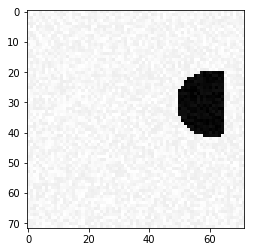

[0.10662749 0.75354964 0.13982289]


In [24]:
# Predicting with the the new model : 
Y_conv_pred=model_conv.predict(X_test5.reshape(300,72,72,1))
plt.imshow(X_test5[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
print(Y_conv_pred[2])

The model seems to have recognize the circle, as the biggest value is in the second column.

In [25]:
# Evaluate the model :
model_conv.evaluate(X_test5.reshape(300,72,72,1), Y_test5, batch_size=16) 

300/300 [==============================] - 1s 2ms/step


[0.6292524202664693, 0.7566666658719381]

The model achieved 81% of accuracy, which is way better than the linear classifiers of before. 

## 6. A Regression Problem

We want to predict the image locations of the vertices of a triangle, given an image of this triangle. 
I generated a training set of 800 samples and visualized some images and predictions using the visualize_prediction function.
Then, I built a regressor using convolutions and evaluated its performance using the mean squared error (as we are in a regression case). 
I considered normalizing the vertices in Y_train and Y_test before training and testing but the results were less accurate (increase of the MSE). Thus, I decided to keep the vectors as they were. I ordered in the generate triangle function the vertices to help the training. It improved the results.


In [26]:
# Generate a training set
[X_train_6, Y_train_6] = generate_dataset_regression(800, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790


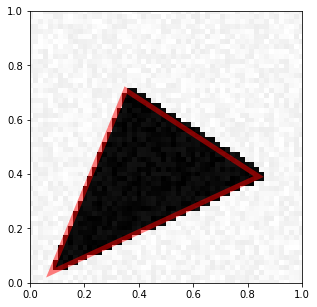

In [27]:
# Visualizing the data :
visualize_prediction(X_train_6[3], Y_train_6[3])

We want to predict the 'U' and 'V' of the generate a triangle function, corresponding to the "corners", so 6 coordinates (2 times 3). Our model will finish with a layer with 6 neurons.

In [28]:
# reshaping X to represent the image in 2 dimensions, 72 by 72.

X_reshaped = X_train_6.reshape((800,72,72))

I tried different models, and will present the best performing one. 

In [29]:
# Importing the needed elements
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

# We create a sequential model
model_6=Sequential()

# We add 3 convolutional layers, with relu activation :

model_6.add(Conv2D(128, 5, activation='relu', input_shape=(72,72,1)))
model_6.add(Conv2D(64, 5, activation='relu'))
model_6.add(Conv2D(32, 5, activation='relu'))

# We use MaxPooling
model_6.add(MaxPooling2D(pool_size=3))

# We need to use flatten before using dense
model_6.add(Flatten())

# We reduce the number of features with Dropout
model_6.add(Dropout(0.2))

# We add a Dense layer
model_6.add(Dense(16,activation='relu'))

# And as we want to predict 6 values, our final layer is a Dense with 6 neurons
# and a linear (identity) activation
model_6.add(Dense(6,activation='linear'))

# Define optimization framework

model_6.compile(loss='mean_squared_error', optimizer='adam')

# After running it, we saw that we could stop at 30 epochs to have an optimal loss.
earlystop=EarlyStopping(monitor='val_loss', patience=7)
model_6.fit(X_reshaped.reshape(800,72,72,1), Y_train_6, epochs=30, 
             batch_size=32,validation_split=0.2,callbacks=[earlystop])

Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 77s 120ms/step - loss: 0.3266 - val_loss: 0.0805
Epoch 2/30
640/640 [==============================] - 71s 110ms/step - loss: 0.0796 - val_loss: 0.0789
Epoch 3/30
640/640 [==============================] - 68s 106ms/step - loss: 0.0745 - val_loss: 0.0658
Epoch 4/30
640/640 [==============================] - 449s 701ms/step - loss: 0.0697 - val_loss: 0.0566
Epoch 5/30
640/640 [==============================] - 66s 103ms/step - loss: 0.0488 - val_loss: 0.0442
Epoch 6/30
640/640 [==============================] - 69s 107ms/step - loss: 0.0418 - val_loss: 0.0418
Epoch 7/30
640/640 [==============================] - 67s 104ms/step - loss: 0.0383 - val_loss: 0.0393
Epoch 8/30
640/640 [==============================] - 67s 104ms/step - loss: 0.0357 - val_loss: 0.0376
Epoch 9/30
640/640 [==============================] - 68s 106ms/step - loss: 0.0338 - val_loss: 0.0360
Epoch 10/30
640/640 [=====

In [30]:
# We present our results for the model :
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 68, 68, 128)       3328      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        204864    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                204816    
__________

In [31]:
# Test set generation
[X_test_6, Y_test_6] = generate_test_set_regression()
X_test_6=X_test_6.reshape((300,72,72,1))

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [32]:
# Prediction using the model :
Y_test_pred_6=model_6.predict(X_test_6.reshape(300,72,72,1))


In [33]:
# Evaluation of the model : 
model_6.evaluate(X_test_6,Y_test_6)

300/300 [==============================] - 10s 32ms/step


0.022434149036804834

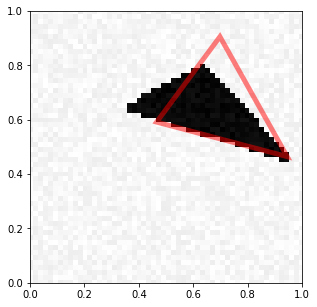

In [34]:
# Plotting the predictions for some values :
visualize_prediction(X_test_6[50], Y_test_pred_6[50])

Conclusion :
- We can see that we obtain a very low value of the MSE
- the predictions are not perfect and vary a lot from an image to another
Thus, the model seems good (especially in comparison to the others tried), but the predictions are not exact. 

## 7. Image Denoising

The goal of the exercise is to predict a noise-free image given a noisy image as input.
First, I created new functions to generate the dataset : each generate_a_* function returns two images, one noisy and a second with no noise. I set the noise as a random number between 150 and 500.

In [35]:
import random

# Remake of the functions
def generate_a_rectangle2(free_location=False):
    figsize = 1.0
    noise=random.randint(150,500)
    U = np.zeros(4)
    V = np.zeros(4)
    corners = np.random.random(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    side = (0.3 + 0.7 * np.random.random()) * figsize
    top = figsize/2 + side/2
    bottom = figsize/2 - side/2
    left = bottom
    right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V)


def generate_a_disk2(free_location=False):
    figsize = 1.0
    noise=random.randint(150,500)
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V)

def generate_a_triangle2(free_location=False):
    figsize = 1.0
    noise=random.randint(150,500)
    if free_location:
        U = np.random.random(3).reshape((1,-1))
        V = np.random.random(3).reshape((1,-1))
        ##sort vertices by increasing x in order to improve the regression outcomes
        vertices = np.concatenate((U,V),axis=0)
        vertices = vertices[:,vertices[0,:].argsort()]
        U = vertices[0]
        V = vertices[1]
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]],[generate_a_drawing(figsize, U, V), [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification2(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle2(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk2(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle2(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification2():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression2(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle2(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def generate_test_set_regression2():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression2(300, 20)
    return [X_test, Y_test]


def generate_dataset_noise(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle2(free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk2(free_location)
        else:
            [X[i], V],[Y[i], U] = generate_a_triangle2(free_location)
    return [X, Y]

In [36]:
# Generating the new dataset, I took an important number of training samples
X_train7,Y_train7=generate_dataset_noise(1000, free_location=False)
X_train7=X_train7.reshape((X_train7.shape[0],72,72,1))
Y_train7=Y_train7.reshape((Y_train7.shape[0],72,72,1))

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


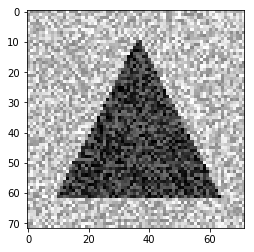

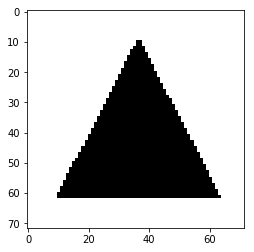

In [37]:
# testing the data generation and the new functions : 
import random 
i=random.randint(0,301)
plt.imshow(X_train7[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(Y_train7[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [38]:
# Checking the impact of the noise in terms of value :
print(X_train7)
print(Y_train7)

[[[[550.56247932]
   [502.65203407]
   [498.50159052]
   ...
   [479.60869061]
   [383.16375554]
   [409.17050839]]

  [[426.29283537]
   [535.31454173]
   [486.94558554]
   ...
   [371.92933864]
   [433.84342893]
   [309.03454524]]

  [[467.88440114]
   [327.99009811]
   [268.46406828]
   ...
   [432.68066125]
   [443.07801333]
   [534.50559258]]

  ...

  [[332.84086053]
   [436.78697779]
   [299.2806684 ]
   ...
   [458.3984863 ]
   [359.21493552]
   [462.50116174]]

  [[423.10466508]
   [380.55736934]
   [550.96289555]
   ...
   [388.67569513]
   [377.67632883]
   [269.19320527]]

  [[286.90025444]
   [513.21407921]
   [365.04622298]
   ...
   [400.26996479]
   [446.11673164]
   [304.68405706]]]


 [[[544.70312385]
   [280.993566  ]
   [405.35785124]
   ...
   [639.26836502]
   [374.9282697 ]
   [267.80654516]]

  [[519.08655824]
   [597.49640012]
   [585.00077047]
   ...
   [580.83937934]
   [663.23324488]
   [322.64784189]]

  [[637.64949037]
   [388.49128392]
   [507.58597944]
 

I implemented a hourglass network for the task with 3 levels (1 left and 1 right). You can find the detail below : 

In [39]:
# Create the U-Net Architecture :
from keras.layers import Input, UpSampling2D
from keras.models import Model
from keras.models import *
from keras.layers import *
from keras.optimizers import *

# We use the function Input to define the inputs
inputs=Input((72,72,1))

# First level : 
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
# Second level :
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# Middle level
conv3=Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)

# First up : 
up4 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv3))
merge4 = concatenate([conv2,up4], axis = 3)
conv4 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)

# Second up : 
up5 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
merge4 = concatenate([conv1,up5], axis = 3)
conv5 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)

# Final level : 
conv6 = Conv2D(1, 3, padding = 'same',activation = 'linear', kernel_initializer = 'he_normal')(conv5)

# defining our model : 
model_unet = Model(input = inputs, output = conv6)
model_unet.compile(optimizer = Adam(lr = 1e-4),
loss = 'mean_squared_error')

model_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 72, 72, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 36, 36, 16)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 36, 36, 32)   4640        max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
max_poolin

/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [40]:
# Fitting the model to the training set :
model_unet.fit(X_train7,Y_train7, 
          epochs=25, batch_size=32,validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/25
800/800 [==============================] - 34s 43ms/step - loss: 69129.6393 - val_loss: 20336.3928
Epoch 2/25
800/800 [==============================] - 27s 34ms/step - loss: 15315.2244 - val_loss: 10822.6521
Epoch 3/25
800/800 [==============================] - 29s 37ms/step - loss: 8947.2974 - val_loss: 7583.9454
Epoch 4/25
800/800 [==============================] - 27s 34ms/step - loss: 6529.0261 - val_loss: 5666.2607
Epoch 5/25
800/800 [==============================] - 27s 33ms/step - loss: 5050.4000 - val_loss: 4563.8427
Epoch 6/25
800/800 [==============================] - 27s 33ms/step - loss: 4208.9154 - val_loss: 3939.3647
Epoch 7/25
800/800 [==============================] - 27s 33ms/step - loss: 3678.7784 - val_loss: 3455.3290
Epoch 8/25
800/800 [==============================] - 27s 33ms/step - loss: 3205.0602 - val_loss: 2976.7184
Epoch 9/25
800/800 [==============================] - 27s 34ms/step - loss: 2778.5686 

In [41]:
# Generating a test set :
X_7test,Y_7test=generate_dataset_noise(200, free_location=False)
X_7test=X_7test.reshape((X_7test.shape[0],72,72,1))
Y_7test=Y_7test.reshape((Y_7test.shape[0],72,72,1))

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


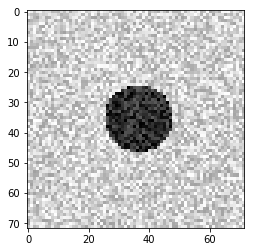

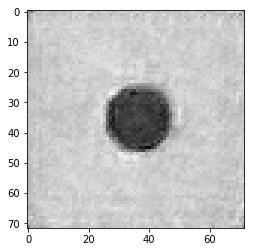

In [42]:
# testing the model 
Y_7_pred=model_unet.predict(X_7test)
plt.imshow(X_7test[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(Y_7_pred[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [43]:
model_unet.evaluate(X_7test,Y_7test)

200/200 [==============================] - 2s 8ms/step


1243.36998046875

Conclusions :
- We can see that we have a very high MSE.
- The predictions are not very accurate.
We tried to increase the training set to 1000 samples to improve the performance but it was not enough.
We could think of changing the depth of each stage of the model, or adding new layers to improve the performance.